<a href="https://colab.research.google.com/github/tangani/State-of-the-art-Clustering-Codependance/blob/master/Shopee_Price_Match_Guarantee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shopee - Price Match Guarantee

In [1]:
import numpy as np
import pandas as pd
import pathlib
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import datetime
import cv2
import math

# import plotly.express as px

import tensorflow as tf
import tensorflow_hub as hub
print('Tensorflow version:',tf.__version__)
print('Tensorflow_hub',hub.__version__)

# Check for GPU availability
print('GPU','available(💪)' if tf.config.list_physical_devices("GPU") else "not available 😢")

Tensorflow version: 2.4.1
Tensorflow_hub 0.11.0
GPU available(💪)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Checking out the labels 

train_csv = pd.read_csv('/content/drive/MyDrive/data_science/shopee-product-matching/train.csv')
train_data = '/content/drive/MyDrive/data_science/shopee-product-matching/train_images/'

test_csv = pd.read_csv('/content/drive/MyDrive/data_science/shopee-product-matching/test.csv')
test_data = '/content/drive/MyDrive/data_science/shopee-product-matching/test_images/'

In [4]:
train_csv['image_path'] = train_data + train_csv.image

In [5]:
train_csv.head()

,posting_id,image,image_phash,title,label_group,image_path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/content/drive/MyDrive/data_science/shopee-pro...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/content/drive/MyDrive/data_science/shopee-pro...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/content/drive/MyDrive/data_science/shopee-pro...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/content/drive/MyDrive/data_science/shopee-pro...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/content/drive/MyDrive/data_science/shopee-pro...


In [6]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
 5   image_path   34250 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.6+ MB


In [7]:
train_csv.isna().sum()

posting_id     0
image          0
image_phash    0
title          0
label_group    0
image_path     0
dtype: int64

## EDA

Text(0, 0.5, 'Occurences')

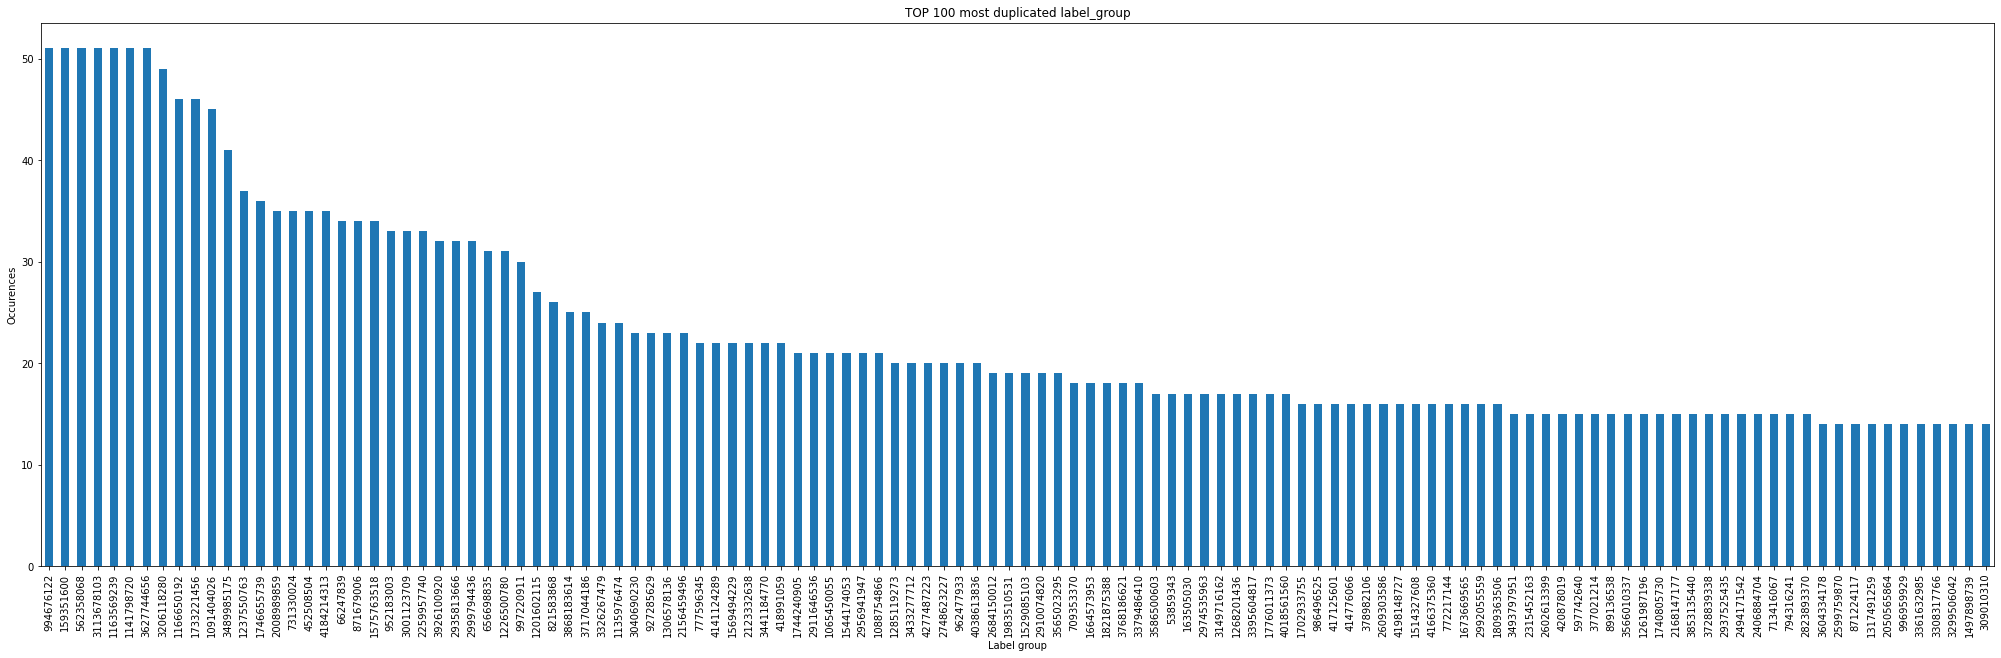

In [8]:
train_csv.label_group.value_counts().nlargest(120).plot.bar(figsize=(35,10))
plt.title("TOP 100 most duplicated label_group")
plt.xlabel("Label group")
plt.ylabel("Occurences")

In [9]:
for col in train_csv.columns:
    print(col + " : " + str(len(train_csv[col].unique())))

posting_id : 34250
image : 32412
image_phash : 28735
title : 33117
label_group : 11014
image_path : 32412


* Some images and titles are appearing more than once
* Due to the nature of the competition, there may be duplicates in label_group, but there are also duplicates in image, image_phash, and title.
* Some images also share image_phash 

In [10]:
# Create new feature to summarize the list of posting_id associated to each label_group value. 
labelled = train_csv.groupby("label_group")["posting_id"].agg("unique")
train_csv["target"] = train_csv.label_group.map(labelled)

In [11]:
train_csv.head()

,posting_id,image,image_phash,title,label_group,image_path,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/content/drive/MyDrive/data_science/shopee-pro...,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/content/drive/MyDrive/data_science/shopee-pro...,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/content/drive/MyDrive/data_science/shopee-pro...,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/content/drive/MyDrive/data_science/shopee-pro...,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/content/drive/MyDrive/data_science/shopee-pro...,"[train_3369186413, train_921438619]"


* Investigate 11014 labels to see how many images in each group

In [14]:
target_labels = train_csv.groupby("label_group")["image"].count().reset_index()
target_labels.columns=["label_group","image_num"]
sorted_labels = target_labels.sort_values("image_num")
sorted_labels

,label_group,image_num
3764,1471548468,2
8718,3381177724,2
4946,1934657835,2
8720,3381497963,2
4943,1932824351,2
...,...,...
2606,994676122,51
8037,3113678103,51
1445,562358068,51
9370,3627744656,51


* This is consistent with the bar chart

#### Looking for more details in terms of images in each label_group

In [16]:
image_count = target_labels.groupby("image_num").count().reset_index()
image_count.columns=["image_num","counts"]
image_count

,image_num,counts
0,2,6979
1,3,1779
2,4,862
3,5,468
4,6,282
5,7,154
6,8,118
7,9,91
8,10,48
9,11,38


##### Visualizing

<BarContainer object of 39 artists>

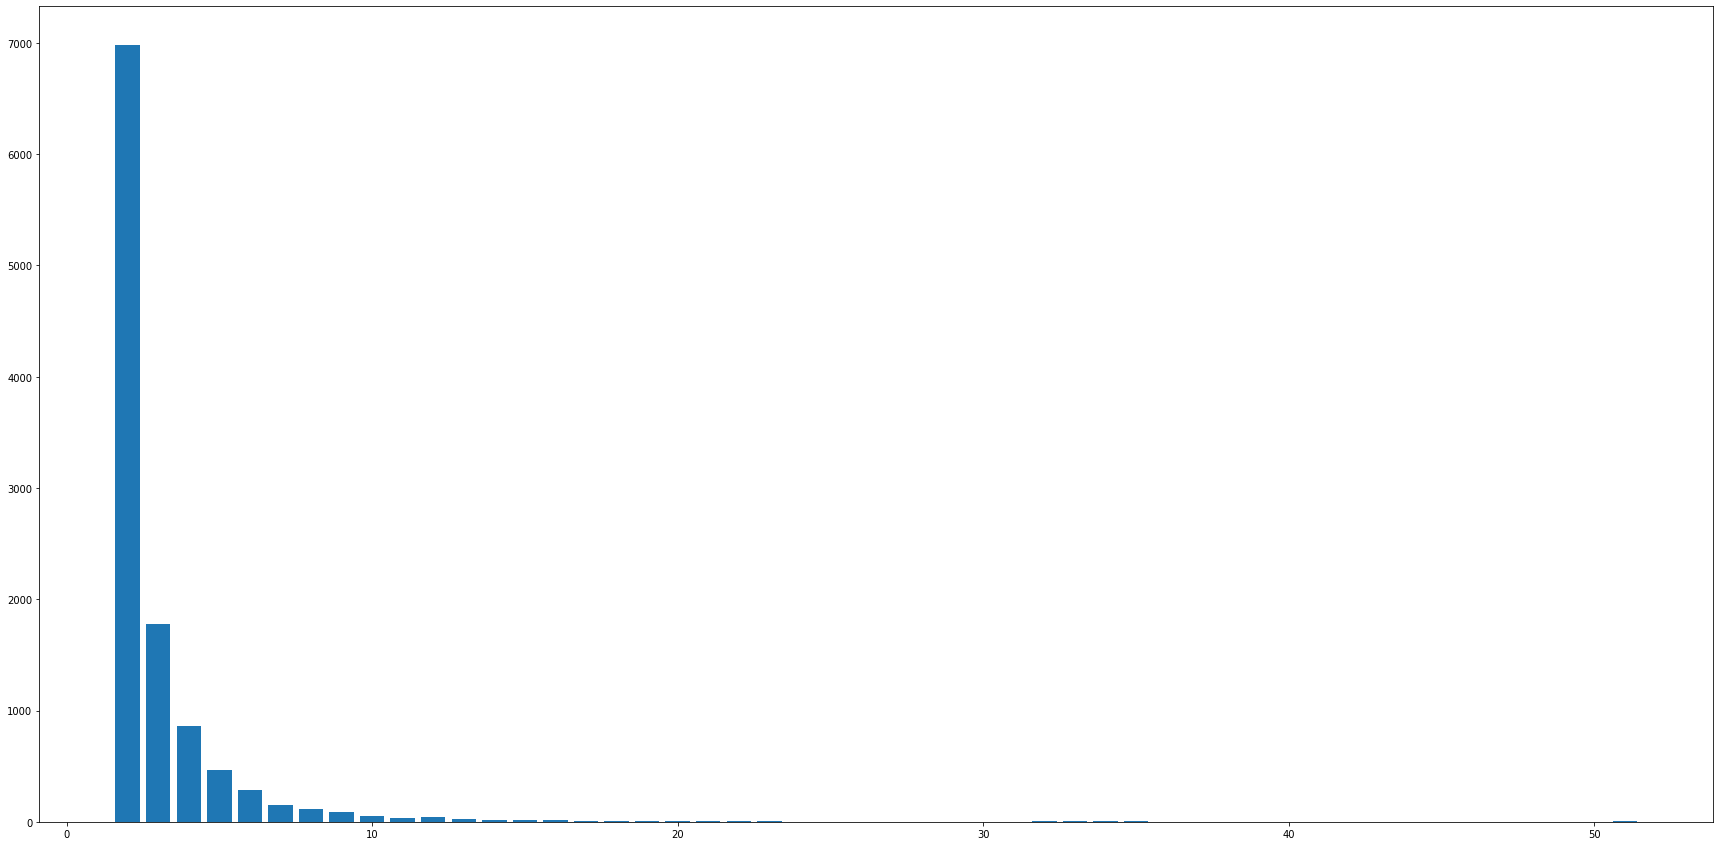

In [21]:
plt.figure(figsize=(30,15))
plt.bar(image_count["image_num"],image_count["counts"])
# figure(figsize=(8, 6), dpi=80)

In [28]:
# Get random label to display pictures within the same group
random_group = train_csv.label_group.sample()
random_group.reset_index(inplace=True, drop=True)
random_label = random_group.get(key = 0)

# Get images in selecte d label group
random_label_group = train_csv.loc[train_csv['label_group'] == random_label]
random_label_group.reset_index(inplace=True, drop=True)
random_label_group

,posting_id,image,image_phash,title,label_group,image_path
0,train_1289458574,016e4664a6a5a0fd95d725e853a504b0.jpg,eca1959a1ec169b5,Speaker Subwoofer Audio Tecnix SPK-S080 Subwoo...,1333574565,/content/drive/MyDrive/data_science/shopee-pro...
1,train_274530042,033b319ce9acf29f935be0a26ea64c88.jpg,b6c1cd3e32d02e0f,Tecnix SPK-S080 Subwoofer Speaker Komputer,1333574565,/content/drive/MyDrive/data_science/shopee-pro...
2,train_1836502843,1b33bdfc48671dc28bf4db22604aa6a7.jpg,ec859a6ea136964b,Tecnix Speaker Bluetooth Subwoofer 2.1 Channel...,1333574565,/content/drive/MyDrive/data_science/shopee-pro...
3,train_2446614659,235cdd72d82da00e9b260ff275a3e877.jpg,eca193169e6b21f4,Speaker Universal SPK-S080 Subwoofer Speaker 2...,1333574565,/content/drive/MyDrive/data_science/shopee-pro...
4,train_3713070752,3deba9781d29d22bb0e04f62cf3567da.jpg,e8ec860f9170999f,Speaker Subwoofer Tecnix SPK-S080 Garansi Resmi,1333574565,/content/drive/MyDrive/data_science/shopee-pro...
5,train_3884768201,e6e60998fb24dbbe52850a0bf737e1d3.jpg,ef819a7ee125960a,Tecnix Speaker Subwoofer 2.1 Channel Design - ...,1333574565,/content/drive/MyDrive/data_science/shopee-pro...
6,train_3214050028,e7b02384581b1398f59843b7e8a32d4b.jpg,eb0594726b8f6790,KIOS HIKAMI - Speaker Subwoofer Audio TECNIX S...,1333574565,/content/drive/MyDrive/data_science/shopee-pro...


/content/drive/MyDrive/data_science/shopee-product-matching/train_images/016e4664a6a5a0fd95d725e853a504b0.jpg 0
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/033b319ce9acf29f935be0a26ea64c88.jpg 1
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/1b33bdfc48671dc28bf4db22604aa6a7.jpg 2
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/235cdd72d82da00e9b260ff275a3e877.jpg 3
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/3deba9781d29d22bb0e04f62cf3567da.jpg 4
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/e6e60998fb24dbbe52850a0bf737e1d3.jpg 5
/content/drive/MyDrive/data_science/shopee-product-matching/train_images/e7b02384581b1398f59843b7e8a32d4b.jpg 6


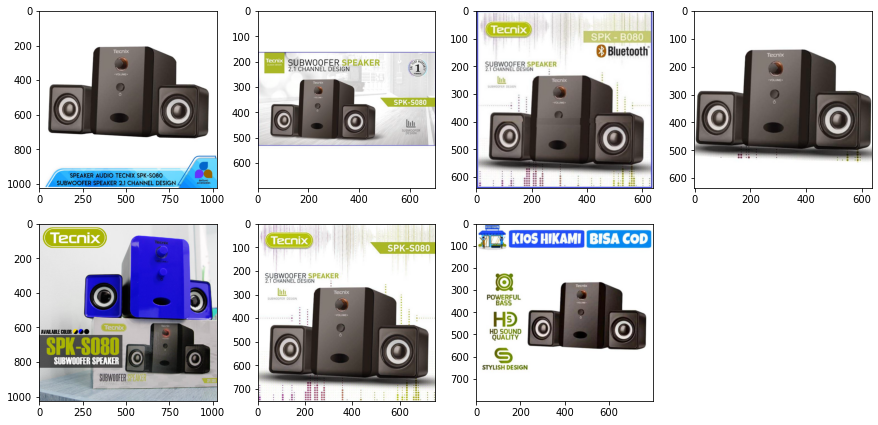

In [29]:
index = random_label_group.index.to_list()

fig = plt.figure(figsize=(30, 7))
rows = math.ceil(len(index)/2)
columns = math.ceil(len(index)/2)
fig.set_figheight(15)
fig.set_figwidth(15)
for x in range(random_label_group.shape[0]):
    print(random_label_group.image_path.get(key = x), x)
    image = cv2.imread(random_label_group.image_path.get(key = x))
    fig.add_subplot(rows, columns, x + 1)
    # print(image)
    plt.imshow(image)

* It is woth noting form the plot above that there are duplicated images within the label_group but different posting_id and image name

##### Investigating image_phash

In [26]:
phash_group = train_csv.groupby("image_phash")["image_path"].count().reset_index()
phash_group.columns=["image_phash","counts"]
sort_phash = phash_group.sort_values("counts", ascending=False)
sort_phash

,image_phash,counts
27584,fad28daa2ad05595,26
16476,d0c0ea37bd9acce0,20
12714,be12e12f9ec1e198,17
21189,e992966d4ba49761,16
26257,f6d98134b904b56b,16
...,...,...
10119,b996c6cb9b82c266,1
10118,b996c6c5ce61c638,1
10117,b996c69992c7d330,1
10116,b996c669962dc986,1


In [37]:
duplicated_image_phash = train_csv[train_csv["image_phash"] == "f6d98134b904b56b"]
duplicated_image_phash

,posting_id,image,image_phash,title,label_group,image_path,target
19543,train_234024597,9320d7a2181b28e6a61317e8ca06ffea.jpg,f6d98134b904b56b,Kitchen Tools Spatula Sendok Masak 1 set isi 6,2156459496,/content/drive/MyDrive/data_science/shopee-pro...,"[train_284834537, train_596453395, train_22181..."
19544,train_3344071220,9320d7a2181b28e6a61317e8ca06ffea.jpg,f6d98134b904b56b,Kitchen tool Sodet Set 6 pcs Spatula Sutil War...,2156459496,/content/drive/MyDrive/data_science/shopee-pro...,"[train_284834537, train_596453395, train_22181..."
19545,train_1195523519,9320d7a2181b28e6a61317e8ca06ffea.jpg,f6d98134b904b56b,SPATULA SET / SODET / SUTIL 6 PCS /SUTIL SET 6...,2156459496,/content/drive/MyDrive/data_science/shopee-pro...,"[train_284834537, train_596453395, train_22181..."
19546,train_2199557904,9320d7a2181b28e6a61317e8ca06ffea.jpg,f6d98134b904b56b,SPATULA SET 6 IN 1 SUTIL ALAT DAPUR NYLON KITC...,2156459496,/content/drive/MyDrive/data_science/shopee-pro...,"[train_284834537, train_596453395, train_22181..."
19547,train_1226331500,9320d7a2181b28e6a61317e8ca06ffea.jpg,f6d98134b904b56b,Sodet Set 6 pcs Spatula Sutil Warna,2156459496,/content/drive/MyDrive/data_science/shopee-pro...,"[train_284834537, train_596453395, train_22181..."
19548,train_1398842640,9320d7a2181b28e6a61317e8ca06ffea.jpg,f6d98134b904b56b,Sodet Set 6 pcs Spatula Sutil Warna ALAT MASAK,2156459496,/content/drive/MyDrive/data_science/shopee-pro...,"[train_284834537, train_596453395, train_22181..."
19549,train_3807557363,9320d7a2181b28e6a61317e8ca06ffea.jpg,f6d98134b904b56b,Sodet Set 6 pcs Spatula Sutil warna biru dan m...,2156459496,/content/drive/MyDrive/data_science/shopee-pro...,"[train_284834537, train_596453395, train_22181..."
19550,train_2063040992,9320d7a2181b28e6a61317e8ca06ffea.jpg,f6d98134b904b56b,Sodet Set 6 pcs Spatula Warna,2156459496,/content/drive/MyDrive/data_science/shopee-pro...,"[train_284834537, train_596453395, train_22181..."
19551,train_1846456008,9320d7a2181b28e6a61317e8ca06ffea.jpg,f6d98134b904b56b,[600gr] H035 | NYLON KITCHEN TOOLS SET 6 PCS /...,2156459496,/content/drive/MyDrive/data_science/shopee-pro...,"[train_284834537, train_596453395, train_22181..."
19738,train_2991399778,94755fc8a93441d30f8b26fdbfa6eb80.jpg,f6d98134b904b56b,Spatula Set 6 In 1 - Peralatan Tumis Masak Cen...,2156459496,/content/drive/MyDrive/data_science/shopee-pro...,"[train_284834537, train_596453395, train_22181..."


* Same phash but different images. There is a need to investigate the issue visually a bit more {This was confirmed earlier by using the counts}

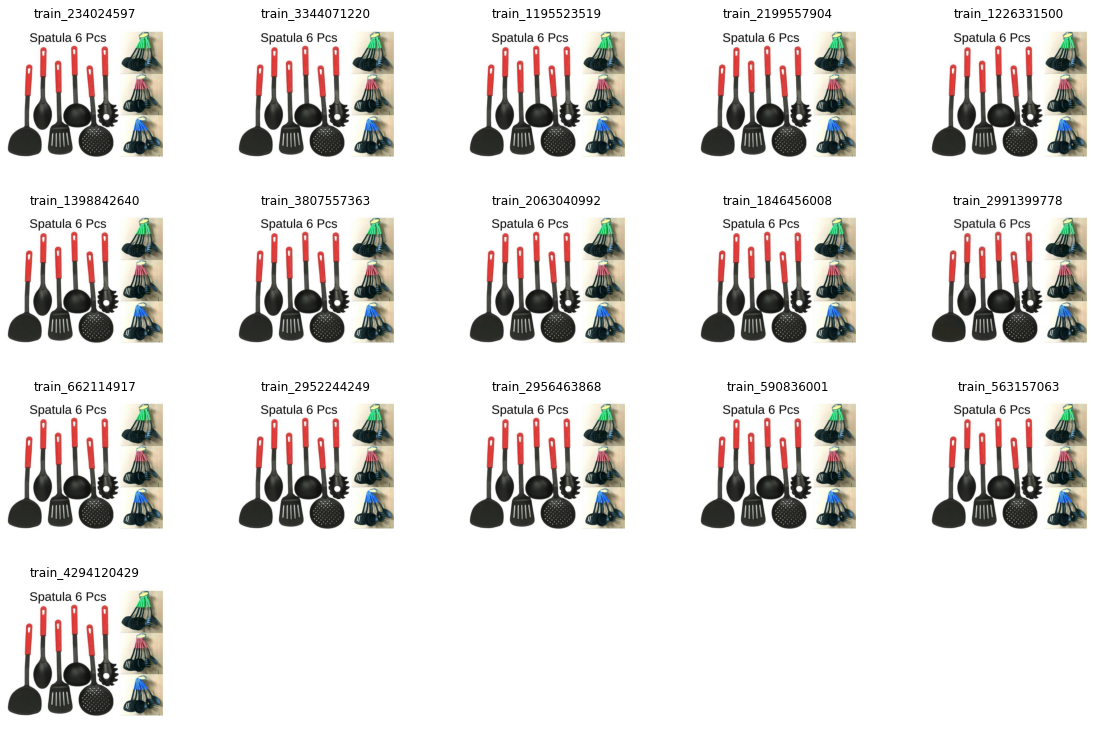

In [40]:
plt.figure(figsize=(20,20))

for num, entry in enumerate(duplicated_image_phash["image_path"]):
    plt.subplot(6, 5, num + 1)
    img = cv2.imread(entry)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.axis("off")
    plt.title(duplicated_image_phash["posting_id"].iloc[num])
    plt.imshow(img)
    

* [Images are different](https://en.wikipedia.org/wiki/Perceptual_hashing) [but all look the same](https://people.cs.umass.edu/~liberato/courses/2020-spring-compsci590k/lectures/09-perceptual-hashing/)